# Projeto - Previsão de Risco de Crédito

## 1. Introdução

A análise de risco de crédito é um dos problemas mais clássicos e de maior impacto no setor financeiro. A concessão de crédito, seja para pessoas físicas ou jurídicas, é a base da atividade bancária, mas carrega consigo o risco inerente da inadimplência. Uma decisão de crédito equivocada pode levar a perdas financeiras significativas, enquanto uma política excessivamente conservadora pode resultar na perda de bons clientes e oportunidades de negócio valiosas.

Neste contexto, a ciência de dados emerge como uma ferramenta estratégica, permitindo que as instituições financeiras migrem de análises subjetivas e manuais para modelos preditivos objetivos, consistentes e escaláveis.

### 1.1. Descrição do problema

O problema central consiste em desenvolver um sistema inteligente capaz de classificar novos solicitantes de crédito em duas categorias: "bom risco" (provável que pague o empréstimo) e "mau risco" (provável que não pague o empréstimo).

Para esta análise, será utilizado conjunto de dados Statlog (German Credit Data), proveniente do repositório da UCI. Este dataset contém informações sobre 1.000 solicitantes de crédito na Alemanha, cada um descrito por 20 atributos, que incluem:

> Informações demográficas: idade, sexo, status civil.
> 
> Informações financeiras: status da conta corrente, histórico de crédito, valor e propósito do empréstimo, existência de poupança.
> 
> Informações profissionais e de moradia: tempo de emprego, tipo de trabalho, tipo de moradia.

A variável-alvo, risk, é binária, indicando se o cliente foi classificado como um bom ou mau pagador. Um desafio técnico relevante neste dataset é o desbalanceamento de classes, onde o número de "bons pagadores" é significativamente maior que o de "maus pagadores". Modelos treinados em dados desbalanceados podem se tornar tendenciosos, o que pode fazê-los performar mal ao identificar a classe minoritária, que é justamente a mais crítica para o negócio.

### 1.2. Objetivo

O objetivo principal deste projeto é construir um modelo de machine learning de classificação binária que preveja com alta acurácia e, mais importante, com alto poder de discriminação, a probabilidade de um solicitante de crédito se tornar inadimplente.

## 2. Configuração do Ambiente 

### 2.1 Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import skrub
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_ingestion import ingest_credit_data
from src import config

## 3. Carregamento dos Dados

### 3.1. Leitura do Conjunto de Dados

In [30]:
# Utiliza a URL definida no arquivo de configuração
url = config.GERMAN_CREDIT_ZIP_URL

# Carrega o arquivo através da URL
df = ingest_credit_data(url, True)

2025-10-25 15:19:05 - INFO - >>> INICIANDO O PIPELINE DE INGESTÃO DE DADOS <<<
2025-10-25 15:19:05 - INFO - Iniciando download de https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip
2025-10-25 15:19:06 - INFO - Arquivos extraídos com sucesso para: C:\Users\user\OneDrive\Documentos\HG\Projetos\Data-Science\credit-risk-prediction\data\raw
2025-10-25 15:19:06 - INFO - Procurando por arquivo '.data' em 'C:\Users\user\OneDrive\Documentos\HG\Projetos\Data-Science\credit-risk-prediction\data\raw'...
2025-10-25 15:19:06 - INFO - Arquivo alvo encontrado: 'german.data'
2025-10-25 15:19:06 - INFO - Arquivo renomeado para: 'credit_data.data'
2025-10-25 15:19:06 - INFO - Arquivo movido para: 'C:\Users\user\OneDrive\Documentos\HG\Projetos\Data-Science\credit-risk-prediction\data\processed'
2025-10-25 15:19:06 - INFO - Arquivo extra 'german.data-numeric' removido.
2025-10-25 15:19:06 - INFO - Arquivo extra 'german.doc' removido.
2025-10-25 15:19:06 - INFO - Arquivo extra 'Ind

### 3.2. Visualização Inicial

In [3]:
# Gera um relatório exploratório interativo da tabela utilizando o TableReport do pacote skrub,
# que será exibido no navegador. Os logs são temporariamente ocultados durante sua criação.
logging.getLogger().setLevel(logging.ERROR)
skrub.TableReport(df).open()
logging.getLogger().setLevel(logging.INFO)

Processing column  21 / 21


## 4. Limpeza dos Dados

Verificação de dados ausentes, nulos e duplicados.

In [4]:
# Verifica o número de valores ausentes por coluna
missing_values = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values)

Valores ausentes por coluna:
checking_account_status       0
duration_in_month             0
credit_history                0
purpose                       0
credit_amount                 0
savings_account_bonds         0
present_employment_since      0
installment_rate_percent      0
personal_status_and_sex       0
other_debtors_guarantors      0
present_residence_since       0
property                      0
age_in_years                  0
other_installment_plans       0
housing                       0
number_of_existing_credits    0
job                           0
number_of_dependents          0
telephone                     0
foreign_worker                0
risk                          0
dtype: int64


In [5]:
# Conta o número total de valores NaN no DataFrame
num_nan = df.isnull().sum().sum()
print(f"Número total de valores NaN: {num_nan}")

# Conta o número total de valores nulos (incluindo None) no DataFrame
num_null = df.isna().sum().sum()
print(f"Número total de valores nulos: {num_null}")

Número total de valores NaN: 0
Número total de valores nulos: 0


In [6]:
# Verifica se existem valores duplicados
num_duplicates = df.duplicated().sum()
print(f"Número de linhas duplicadas: {num_duplicates}")

Número de linhas duplicadas: 0


In [7]:
# Exibe amostra de linhas duplicadas, caso exista
if num_duplicates > 0:
    print("Exemplo de linhas duplicadas:")
    display(df[df.duplicated()])

## 5. Análise da Variável Alvo

### 5.1. Mapeamento da Variável Alvo

Conversão dos valores originais (1, que representa 'bom risco', e 2, que representa 'mau risco') para o formato binário padrão 0 e 1, em que 0 representa o 'mau risco' e 1 representa o 'bom risco'.

In [ ]:
# Exibe os valores únicos originalmente presentes na coluna 'risk'
print("Valores possíveis na variável 'risk' antes do mapeamento:")
print([int(x) for x in sorted(df['risk'].unique())])
print()
print("Legenda:")
print("1 = Bom risco")
print("2 = Mau risco")
print()

# Realiza o mapeamento: 1 (bom risco) -> 1, 2 (mau risco) -> 0
df['risk'] = df['risk'].map({1: 1, 2: 0})

# Exibe os valores únicos após o mapeamento
print("Valores possíveis na variável 'risk' após o mapeamento:")
print([int(x) for x in sorted(df['risk'].unique())])
print()
print("Legenda:")
print("0 = Mau risco")
print("1 = Bom risco")

Valores possíveis na variável 'risk' antes do mapeamento:
[1, 2]

Legenda:
1 = Bom risco
2 = Mau risco

Valores possíveis na variável 'risk' após o mapeamento:
[0, 1]

Legenda:
0 = Mau risco
1 = Bom risco


### 5.2. Análise da Distribuição

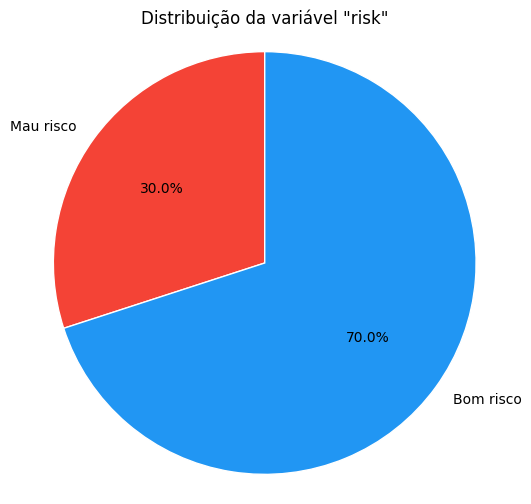

Distribuição:
risk
0    300
1    700
Name: count, dtype: int64

Legenda:
0 = Mau risco
1 = Bom risco


In [34]:
# Plota um gráfico de setores que mostra a distribuição das classes da variável alvo 'risk'.
risk_counts = df['risk'].value_counts().sort_index()  
labels = ['Mau risco' if v==0 else 'Bom risco' for v in risk_counts.index]
sizes = risk_counts.values
colors = ['#F44336', '#2196F3']

plt.figure(figsize=(6,6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=colors, 
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Distribuição da variável "risk"')
plt.axis('equal')
plt.show()

# Verifica a distribuição dos valores de da variável alvo'risk'.
print("Distribuição:")
print(df['risk'].value_counts().sort_index())
print()
print("Legenda:")
print("0 = Mau risco")
print("1 = Bom risco")


Com base nesses dados, percebe-se que, a classe majoritária, 'bom risco', compõe 70% das amostras, enquanto a classe minoritária, 'mau risco', representa os 30% restantes.

#### Análise do Desbalanceamento

Razão de desbalanceamento (Imbalance ratio):

IR = Classe majoritária / Classe minoritária = 700/300 = `2.33`

Esse valor indica um desbalanceamento leve, mas, ainda assim, é necessário uma atenção durante a modelagem para evitar um possível viés que favoreça a classe majoritária. 

##### Implicações para o negócio

- Aproximadamente 1 a cada 3 solicitantes de crédito é considerado 'mau risco'.
- A taxa de 30% é considerável, o que justifica o investimento em modelos preditivos para minimizar os erros de previsão do risco de crédito.

##### Implicações para a modelagem

- Apesar do desbalanceamento leve, será uma boa prática utilizar técnicas de balanceamento, para garantir que o modelo aprenda adequadamente os padrões da classe minoritária ('mau risco').
- Utilizar métricas alternativas para a avaliação do modelo.

#### Custos de Erros

- **Falso negativo**: Classificar um "mau pagador" como "bom pagador". Possui alto custo financeiro. 
- **Falso positivo**: Classificar um "bom pagador" como "mau pagador". Representa a perda de uma oportunidade de negócio.

É essencial que o modelo priorize a identificação correta de "maus pagadores", mesmo que isso signifique aumentar o número de falsos positivos.